In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [104]:
ANNOT_SHUFF_ACTORS_PATH = "download_scripts/shuffled_facescrub_actors.txt"
ANNOT_ACTORS_PATH = "data/facescrub_actors.txt"
ANNOT_ACTRESS_PATH = "data/facescrub_actresses.txt"
DATA_ACTORS_PATH = "data/actor/"
DATA_ACTRESS_PATH = "data/actress/"

ANNOT_PATH = "data/full_facescrub.txt"
DATA_PATH = "data/"


## bbox
The coordinates of the bounding box for a face in the image. The format is x1,y1,x2,y2, where (x1,y1) is the coordinate of the top-left corner of the bounding box and (x2,y2) is that of the bottom-right corner, with (0,0) as the top-left corner of the image.  Assuming the image is represented as a Python Numpy array I, a face in I can be obtained as I[y1:y2, x1:x2].

In [6]:
def show_full_and_crop(actor, img_id, face_id, bbox):
    img_name = actor + '_' + img_id + '.jpeg'
    img_face_name = actor + '_' + img_id + '_' + face_id + '.jpeg'
    
    img = io.imread(os.path.join(DATA_ACTORS_PATH, 'images', actor, img_name))
    face = io.imread(os.path.join(DATA_ACTORS_PATH, 'faces', actor, img_face_name))
    
    plt.figure()
    plt.subplot(121)
    plt.imshow(img)
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], ec='k', fc='none'))
    plt.subplot(122)
    plt.imshow(face)

In [106]:
class FaceScrubDataset(Dataset):
    '''FaceScrub Dataset'''
    
    def __init__(self, txt_file, root_dir, crop_face=True, transform=None):
        """
        Args:
            txt_file (string): Path to the txt file with annotations
            root_dit (string): Directory with all the images
            crop_face (bool): To decide to get the cropped face or full image
            transform (callable, optional): optional transform on a sample
        """
        self.faces_frame = pd.read_csv(txt_file, delimiter='\t')
        self.root_dir = root_dir
        self.transform = transform
        self.crop_face = crop_face
    
    def __len__(self):
        return len(self.faces_frame)
    
    def __getitem__(self, idx):
        self.name = self.faces_frame.iloc[idx]['name']
        self.img_id = self.faces_frame.iloc[idx]['image_id'].astype('str')
        self.face_id = self.faces_frame.iloc[idx]['face_id'].astype('str')
        self.gender = self.faces_frame.iloc[idx]['gender']
        self.bbox = self.faces_frame.iloc[idx]['bbox']
        self.bbox = list(map(int, self.bbox.split(',')))
        
        if self.gender == 'male':
            data_path = os.path.join(DATA_PATH, 'actor')
        elif self.gender == 'female':
            data_path = os.path.join(DATA_PATH, 'actress')
    
        if self.crop_face:
            img_name = self.name.replace(' ', '_') + '_' + self.img_id + '_' + self.face_id + '.jpeg'
            img_path = os.path.join(data_path, 'faces', self.name.replace(' ', '_'), img_name)
            img = io.imread(img_path)
        else:
            img_name = self.name.replace(' ', '_') + '_' + self.img_id + '.jpeg'
            img_path = os.path.join(data_path, 'images', self.name.replace(' ', '_'), img_name)
            img = io.imread(img_path)
        
        sample = {'image': img, 'name': self.name, 'gender': self.gender, 
                  'img_id': self.img_id, 'face_id': self.face_id}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample         

1 (365, 365, 3) Aaron Eckhart 1
2 (772, 772, 3) Aaron Eckhart 3
3 (216, 216, 3) Aaron Eckhart 5


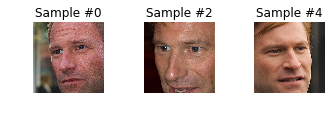

In [46]:
faces_dataset = FaceScrubDataset(txt_file=ANNOT_PATH, root_dir=DATA_PATH)

fig = plt.figure()
count = 0
for i in range(len(actor_dataset)):
    try:
        sample = actor_dataset[i]
    except FileNotFoundError:
        continue
    count += 1
    print(count, sample['image'].shape, sample['name'], sample['img_id'])
    
    ax = plt.subplot(1, 4, count+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(sample['image'])
    
    if count == 3:
        plt.show()
        break

In [59]:
class Rescale(object):
    '''
    Rescale the image in a sample to a give size.
    
    Args:
        output_size (tuple or int): Desired output size. If tuple
        output is matched to output_size. If int, smaller of 
        image edges is matched to output_size keeping aspect 
        ratio the same.
    '''
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, name, img_id, face_id = sample['image'], sample['name'], sample['img_id'], sample['face_id']
        
        h, w = image.shape[:2]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        
        return {'image': img, 'name': name, 'img_id': img_id, 'face_id': face_id}

In [66]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        image, name, img_id, face_id = sample['image'], sample['name'], sample['img_id'], sample['face_id']
        
        # swap color axis because 
        # numpy image: HxWxC
        # torch image: CxHxW
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
               'name': name, 'img_id': img_id, 'face_id': face_id}

/afs/inf.ed.ac.uk/user/s17/s1791387/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


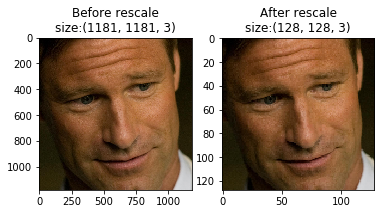

In [67]:
scale = Rescale(128)

fig = plt.figure()
sample = actor_dataset[8]
transformed_sample = scale(sample)

plt.subplot(121)
plt.title('Before rescale\nsize:{}'.format(sample['image'].shape))
plt.imshow(sample['image'])
plt.subplot(122)
plt.title('After rescale\nsize:{}'.format(transformed_sample['image'].shape))
plt.imshow(transformed_sample['image'])
plt.show()

In [69]:
transformed_actors_dataset = FaceScrubDataset(txt_file=ANNOT_ACTORS_PATH, 
                                              root_dir=DATA_ACTORS_PATH, 
                                              transform = transforms.Compose([
                                                  Rescale(256), 
                                                  ToTensor()
                                              ]))

count = 0
for i in range(len(transformed_actors_dataset)):
    try:
        sample = transformed_actors_dataset[i]
    except FileNotFoundError:
        continue
    count += 1
    print(count, sample['image'].size(), sample['name'], sample['face_id'])
    
    if count == 3:
        break

1 torch.Size([3, 256, 256]) Aaron Eckhart 1
2 torch.Size([3, 256, 256]) Aaron Eckhart 3
3 torch.Size([3, 256, 256]) Aaron Eckhart 5


/afs/inf.ed.ac.uk/user/s17/s1791387/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [70]:
dataloader = DataLoader(transformed_actors_dataset, batch_size=4, shuffle=True, num_workers=4)

def show_images_batch(sample_batched):
    """Show a batch of samples"""
    
    images_batch, names_batch, face_id = sample_batched['images'], sample_batched['name'], sample_batched['face_id']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(), 
         sample_batched['name'])
    
    if i_batch == 3:
        plt.figure()
        show_images_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

FileNotFoundError: Traceback (most recent call last):
  File "/afs/inf.ed.ac.uk/user/s17/s1791387/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/afs/inf.ed.ac.uk/user/s17/s1791387/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 55, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-45-c958dd9c81aa>", line 30, in __getitem__
    img = io.imread(img_path)
  File "/afs/inf.ed.ac.uk/user/s17/s1791387/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/skimage/io/_io.py", line 61, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/afs/inf.ed.ac.uk/user/s17/s1791387/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/skimage/io/manage_plugins.py", line 211, in call_plugin
    return func(*args, **kwargs)
  File "/afs/inf.ed.ac.uk/user/s17/s1791387/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/skimage/io/_plugins/pil_plugin.py", line 35, in imread
    with open(fname, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: 'data/actor/faces/Michael_Landes/Michael_Landes_82225_43641.jpeg'


/afs/inf.ed.ac.uk/user/s17/s1791387/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/afs/inf.ed.ac.uk/user/s17/s1791387/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
